In [1]:
import numpy as np
import torch
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn
import sys
seaborn.set()

import warnings
warnings.filterwarnings("ignore")

import reservoir
import reckernel
from kuramoto import KS
%load_ext autoreload
%autoreload 2
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
L    = 22 / (2 * np.pi)
N    = 100
dt   = 0.25
ninittransients = 1000
tend = 5000 + ninittransients*dt  #50000
dns  = KS(L=L, N=N, dt=dt, tend=tend)

N_data_train = 10000
N_data_test = 10000

dns.simulate()
u = dns.uu[ninittransients:] / np.sqrt(N)
[u_train, u_test, _] = np.split(u, [N_data_train, N_data_train+N_data_test], axis=0)

In [12]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon_range = 10
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

n_res = 1000
input_scale = 0.014
res_scale = 0.8
leak_rate = 0.6

initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf', leak_rate=leak_rate)
X = model.forward(u_train_t, initial_state=initial_state).to(device)

output_w = model.train(X, out_train, alpha=1e-4)
pred_output = X @ output_w

Xtest = model.forward(u_test_t, initial_state=initial_state).to(device)
pred_output_test = Xtest @ output_w

n_rec_pred = 2000
Xtest = Xtest[:n_rec_pred, :]

input_dim = 100
n_rec = 20
test_rec_pred = model.rec_pred(Xtest, output_w, n_rec, input_dim)
print(test_rec_pred.shape)

torch.Size([2000, 20100])


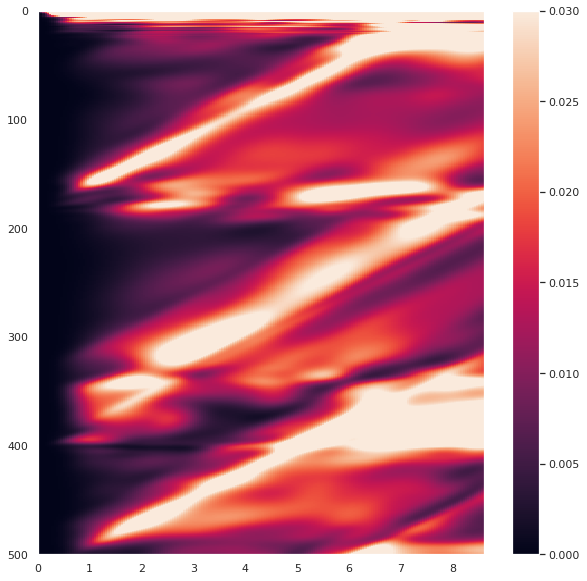

In [81]:
new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(input_len, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)

rec_pred = test_rec_pred.reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
truth = out_test[:n_rec_pred, :].reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
diff = rec_pred - truth
test = torch.mean(diff**2, dim=2)[:500, :]
plt.figure(figsize=(10,10))
plt.imshow(test.cpu(), aspect='auto', vmin=0, vmax=0.03, extent=[0, 200*0.043, 500, 0])
plt.grid(b=None)
plt.colorbar()

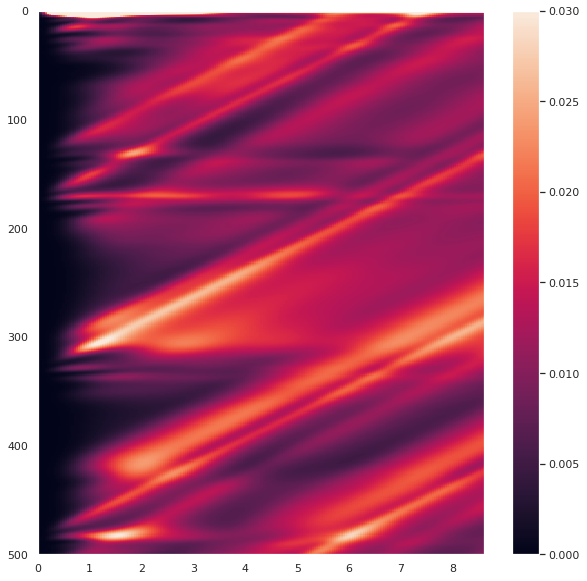

In [13]:
new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(input_len, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)

rec_pred = test_rec_pred.reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
truth = out_test[:n_rec_pred, :].reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
diff = rec_pred - truth
test = torch.mean(diff**2, dim=2)[:500, :]
plt.figure(figsize=(10,10))
plt.imshow(test.cpu(), aspect='auto', vmin=0, vmax=0.03, extent=[0, 200*0.043, 500, 0])
plt.grid(b=None)
plt.colorbar()

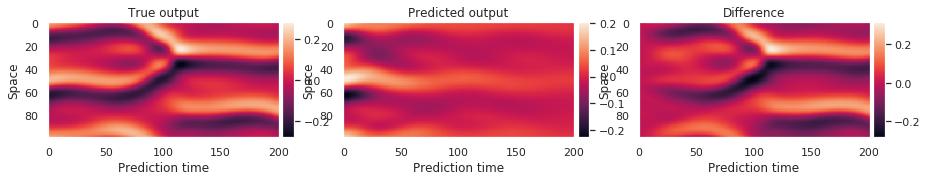

In [14]:
origin = 220
pred_plot = test_rec_pred[origin, :].reshape((n_rec+1)*pred_horizon_range, input_dim)

new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(input_len, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)

true_plot = out_test[origin, :].reshape(-1, input_dim).cpu()

from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(true_plot.T)
axes[0].grid(b=None)
axes[0].set_xlabel("Prediction time")
axes[0].set_ylabel("Space")
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(pred_plot.T)
axes[1].grid(b=None)
axes[1].set_xlabel("Prediction time")
axes[1].set_ylabel("Space")
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow(((true_plot-pred_plot)).T)
axes[2].grid(b=None)
axes[2].set_xlabel("Prediction time")
axes[2].set_ylabel("Space")
axes[2].set_title("Difference");
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

In [67]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon_range = 1
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

n_res = 1000
input_scale_vec = np.arange(start=0.002, stop=0.02, step=0.004)
res_scale_vec = np.arange(start=0.6, stop=1.1, step=0.1)
leak_rate_vec = np.arange(start=0.6, stop=1.01, step=0.1)
err = torch.zeros(len(input_scale_vec), len(res_scale_vec), len(leak_rate_vec))

for i, input_scale in tqdm(enumerate(input_scale_vec)):
    for j, res_scale in enumerate(res_scale_vec):
        for k, leak_rate in enumerate(leak_rate_vec):

            initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
            model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                                  f='erf', leak_rate=leak_rate)
            X = model.forward(u_train_t, initial_state=initial_state).to(device)

            output_w = model.train(X, out_train, alpha=1e-4)
            pred_output = X @ output_w

            Xtest = model.forward(u_test_t, initial_state=initial_state).to(device)
            pred_output_test = Xtest @ output_w

            n_rec_pred = 4000
            Xtest = Xtest[:n_rec_pred, :]

            input_dim = 100
            n_rec = 200
            test_rec_pred = model.rec_pred(Xtest, output_w, n_rec, input_dim)

            new_pred_horizon = pred_horizon_range * (n_rec+1)
            out_test = torch.zeros(input_len, input_dim * new_pred_horizon).to(device)
            for pred_horizon in range(1, new_pred_horizon+1):
                out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)

            rec_pred = test_rec_pred.reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
            truth = out_test[:n_rec_pred, :].reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
            diff = rec_pred - truth
            mse = torch.mean(diff**2, dim=2)[100:, :] # remove the first points to removce initialization artefacts
            err[i, j, k] = torch.mean(mse)

5it [12:38, 151.77s/it]


In [68]:
print(err.shape)
print(np.squeeze(err))

torch.Size([5, 6, 5])
tensor([[[0.0116, 0.0117, 0.0118, 0.0119, 0.0121],
         [0.0118, 0.0117, 0.0116, 0.0116, 0.0116],
         [0.0115, 0.0115, 0.0116, 0.0116, 0.0117],
         [0.0118, 0.0121, 0.0119, 0.0120, 0.0121],
         [0.0135, 0.0129, 0.0127, 0.0129, 0.0157],
         [0.0760, 0.0646, 0.0550, 0.0587, 0.0173]],

        [[0.0121, 0.0120, 0.0118, 0.0116, 0.0116],
         [0.0116, 0.0118, 0.0119, 0.0119, 0.0119],
         [0.0112, 0.0112, 0.0113, 0.0113, 0.0114],
         [0.0126, 0.0129, 0.0128, 0.0129, 0.0151],
         [0.0643, 0.0421, 0.0527, 0.0919, 0.0181],
         [0.1806, 0.5752, 0.1798, 0.0460, 0.0216]],

        [[0.0121, 0.0122, 0.0122, 0.0121, 0.0119],
         [0.0114, 0.0115, 0.0116, 0.0117, 0.0119],
         [0.0111, 0.0111, 0.0112, 0.0112, 0.0113],
         [0.0161, 0.0164, 0.0170, 0.0170, 0.0282],
         [0.2636, 0.3761, 0.3067, 0.2034, 0.0736],
         [0.3671, 0.4796, 0.1634, 0.0791, 0.0225]],

        [[0.0117, 0.0120, 0.0122, 0.0123, 0.0123],
   

In [69]:
print(np.min(err.cpu().numpy()))
print(np.argmin(err))

0.011120587
tensor(100)


In [70]:
i, j, k = 3, 2, 0
print(i*30+j*5+k)

100


In [71]:
input_scale = input_scale_vec[i]
res_scale = res_scale_vec[j]
leak_rate = leak_rate_vec[k]

print(input_scale, res_scale, leak_rate)

0.014 0.7999999999999999 0.6


# RK recursive prediction

In [105]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon_range = 5
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

input_scale = 0.01
res_scale = 0.7
len_of_interest = 40

model = reckernel.RecKernel(function='arcsin', memory_efficient=True, n_iter=len_of_interest, res_scale=res_scale, input_scale=input_scale)
K = model.forward(u_train_t).to(device)

out_train = out_train[len_of_interest-1:, :]
output_w = model.train(K, out_train, alpha=1e-6)

test_len = 3000
Ktest, diag_res_train, diag_res_test = model.forward_test(u_train_t, u_test_t[:test_len, :])
pred_output_test = Ktest @ output_w

n_rec = 20
test_rec_pred = model.rec_pred(Ktest, u_train_t, u_test_t, output_w, n_rec, diag_res_train, diag_res_test)

print(K.shape)
print(output_w.shape)
print(pred_output_test.shape)
print(test_rec_pred.shape)

torch.Size([9961, 9961])
torch.Size([9961, 500])
torch.Size([2961, 500])
torch.Size([2961, 10500])


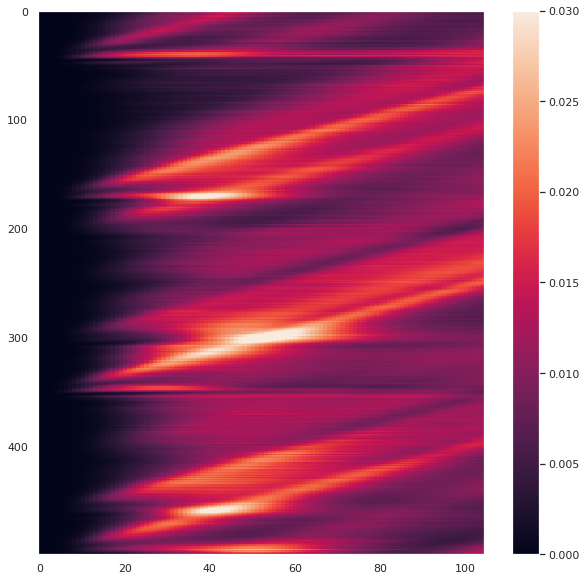

In [106]:
n_rec_pred = test_len - len_of_interest + 1
new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(test_len, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t[:test_len, :], -pred_horizon, dims=0)

rec_pred = test_rec_pred.reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
truth = out_test[len_of_interest-1:, :].reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
diff = rec_pred - truth
test = torch.mean(diff**2, dim=2)[:500, :]
plt.figure(figsize=(10,10))
plt.imshow(test.cpu(), aspect='auto', vmin=0, vmax=0.03) #, extent=[0, 200*0.043, 500, 0])
plt.grid(b=None)
plt.colorbar();

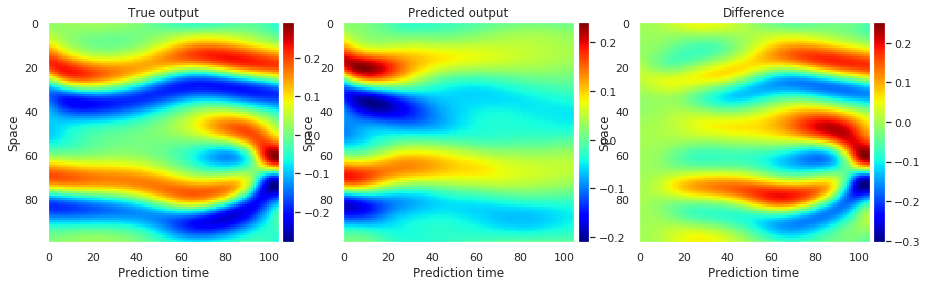

In [107]:
origin = 75
pred_plot = test_rec_pred[origin, :].reshape((n_rec+1)*pred_horizon_range, input_dim)

new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(test_len, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t[:test_len, :], -pred_horizon, dims=0)

true_plot = out_test[len_of_interest+origin, :].reshape(-1, input_dim).cpu()

from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(true_plot.T, cmap='jet')
axes[0].grid(b=None)
axes[0].set_xlabel("Prediction time")
axes[0].set_ylabel("Space")
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)
# plt.colormap('jet')

plot = axes[1].imshow(pred_plot.T, cmap='jet')
axes[1].grid(b=None)
axes[1].set_xlabel("Prediction time")
axes[1].set_ylabel("Space")
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow(((true_plot-pred_plot)).T, cmap='jet')
axes[2].grid(b=None)
axes[2].set_xlabel("Prediction time")
axes[2].set_ylabel("Space")
axes[2].set_title("Difference");
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

In [70]:
pred_train = K @ output_w
print(pred_train.shape)
print(out_train.shape)

origin = 100
pred_plot = pred_train[origin, :].reshape((n_rec+1)*pred_horizon_range, input_dim).cpu()

new_pred_horizon = pred_horizon_range * (n_rec+1)
out_train = torch.zeros(input_len, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

true_plot = out_train[len_of_interest+origin, :].reshape(-1, input_dim).cpu()

from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(true_plot.T, cmap='jet')
axes[0].grid(b=None)
axes[0].set_xlabel("Prediction time")
axes[0].set_ylabel("Space")
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)
# plt.colormap('jet')

plot = axes[1].imshow(pred_plot.T, cmap='jet')
axes[1].grid(b=None)
axes[1].set_xlabel("Prediction time")
axes[1].set_ylabel("Space")
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow(((true_plot-pred_plot)).T, cmap='jet')
axes[2].grid(b=None)
axes[2].set_xlabel("Prediction time")
axes[2].set_ylabel("Space")
axes[2].set_title("Difference");
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

torch.Size([9961, 1000])
torch.Size([9961, 1000])


RuntimeError: shape '[110, 100]' is invalid for input of size 1000

In [ ]:
initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf', leak_rate=leak_rate)
X = model.forward(u_train_t, initial_state=initial_state).to(device)

output_w = model.train(X, out_train, alpha=1e-4)
pred_output = X @ output_w


Xtest = model.forward(u_test_t, initial_state=initial_state).to(device)
pred_output_test = Xtest @ output_w

n_rec_pred = 2000
Xtest = Xtest[:n_rec_pred, :]

input_dim = 100
n_rec = 200
test_rec_pred = model.rec_pred(Xtest, output_w, n_rec, input_dim)
print(test_rec_pred.shape)

In [ ]:

RK = RecKernel(function='arcsin', memory_efficient=True, n_iter=40)
K = RK.forward(input_data)
